# Merging Sensor Data Streams with Python Generators and Priority Queues
> How I used Python generators to process streaming data from maritime sensors.

- toc:true
- badges: true
- comments: true
- author: Luca Cazzanti
- categories: [sensors, streaming data, Python generators]
- image: images/sensors_example.png

A recurring task in multi-sensor data processing is merging -- or interleaving -- data from multiple sensors while maintaining chronological order.  For example, you may be combining temperature readings from different weather stations in a region, stringing together the locations of mobile devices recorded by different cell towers, or piecing together the routes taken by maritime vessels from the data they broadcast through the [Automatic Identification System (AIS)](https://en.wikipedia.org/wiki/Automatic_Identification_System).

Often, the volume of data recorded by each sensor is large compared to the available RAM; other times each sensor's data fits in memory, but the merged, sorted stream does not; yet other times the available RAM is insufficient even for smaller sensor data volumes because the merge-and-sort operation is carried out on a small, lightweight compute node (Raspberry Pi anyone?). For these reasons, maintaining order with the naive approach of concatenating-then-sorting-in-memory is infeasible. Fortunately, we can use Python generators, iterators, and priority queues from the Python package [heapq](https://docs.python.org/2/library/heapq.html) to achieve ordered, merged data streams from multiple sensors with low memory overhead.

## Motivating use case: Vessel draft as a proxy for loading/unloading activity in ports
<img style="float: left; height: 96px; width: 96px; margin-right: 7px" src= "my_icons/draft_marks.jpg" alt="Draft marks picture from Wikipedia" title="Draft marks on a vessel. Source: Wikipedia">

Vessels periodically broadcast their [draft](https://en.wikipedia.org/wiki/Draft_%28hull%29) -- the vertical distance between the waterline and the vessel's keel -- through the AIS protocol. Draft readings are used to ensure that loaded vessels to not run aground in shallower waters. Loading and unloading a vessel changes its draft, which can be used as an indicator of progress in port operations and as a proxy for maritime commerce. When multiple AIS data streams report the draft readings, we need to merge them into one unified stream to enable further vessel analytics, such as change detection.

## Approach
In this post I assume that there are two AIS sensor networks and data from each are stored in two separte database tables. For simplicity I also assume there are only two vessels. AIS messages transmitted by the vessels are stored in the database tables in the order they arrive, along with a time stamp. In this post I use [sqlite3](https://docs.python.org/2.7/library/sqlite3.html) to simulate this system and use synthetic datasets to illustrate the key points.

* To address the requirement to **use little memory**: use lazy evaluation and generators to iterate over the data streams to avoid creating intermediate data containers. In practice, this means iterating over database connection objects, not over the data in the database.
* To address the requirement to **keep sorted order**: delegate sorting of the individual data streams to the database, then use the powerful `heapq.merge()` function to interleave the individual streams into one.

These two techniques have been known to software developers for a long time, but they mey be new to scientists (like me) who do not have formal training in software engineering or databases, but need to analyze large data sets.

## Packages and helper functions

In [1]:
# Import packages and define helper functions for the notebook
import heapq
import sqlite3
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


def head_db(table_name, n):
    """
    Print the first n records from table_name
    """
    query = "SELECT * FROM %s LIMIT %s" % (table_name, n)
    conn = sqlite3.connect('vessel_draft.sqlite')
    conn.row_factory = sqlite3.Row
    result = conn.execute(query)
    for row in result:
        res = {key: row[key] for key in row.keys()}
        print res
    conn.close()

    
def plot_timeseries(data, **kwargs):
    """
    Plot the time series of draft readings for one vessel.
    """
    
    (timestamp, vessel_id, draft) = zip(*data)
    plt.step(timestamp, draft, **kwargs)
    plt.xlabel('Timestamp')
    plt.ylabel('Draft')
    plt.title('Vessel ID = ' + str(vessel_id[0]))
    plt.ylim([min(draft) - 1, max(draft)+1])
    plt.xlim([min(timestamp)-1, max(timestamp)+2])

    
def plot_timeseries_from_tables(table_names):
    """
    Plot the time series of draft readings for one vessel from 2 sensors.
    """
    
    plt.figure()
    conn = sqlite3.connect('vessel_draft.sqlite')
    
    query = "SELECT * FROM %s" % (table_names[0], )
    result = conn.execute(query)
    plot_timeseries(result, where='post', marker='o', color='r', alpha=0.5)
    plt.hold(True)
    
    query = "SELECT * FROM %s " % (table_names[1], )
    result = conn.execute(query)
    plot_timeseries(result, where='post', marker='o', color='b', alpha=0.5)
    plt.legend(['Sensor 1', 'Sensor 2'], loc='lower right')
    
    conn.close() 

    
def plot_multi_series(data):
    """
    Plot the time series of draft readings for 2 vessel from 2 sensors.
    """
    
    vessel1 = filter(lambda row: row[0] == 1, data)
    vessel2 = filter(lambda row: row[0] == 2, data)
    plt.figure(figsize=(10,6))
    plt.subplot(121)
    plot_timeseries(map(lambda row: (row[1], row[0], row[2]), vessel1), where='post', marker='o', color='darkviolet')
    plt.subplot(122)
    plot_timeseries(map(lambda row: (row[1], row[0], row[2]), vessel2), where='post', marker='o', color='darkviolet')
    

## Basic scenario: Two sensors and one vessel
Assume there are two sensors (two database files), each one recording the draft of a single vessel, the timestamp of the draft reading and the vessel `id`. When a new reading is available, each sensor appends the value and the timestamp to its assigned database table.  Below is an example of what the data sources might look like. Note that the timestamps recorded by one sensor need not match the timestamps of the other, because the sensors operate asynchronosuly and each one records only the data it observes. This can be seen in the plot: some draft readings are common to the two sensors (violet color), but each sensor has access to readings not available to the other (red and blue color)

In [2]:
head_db('sensor1_single_vessel', 7)

{'draft': 12.0, 'id': 1, 'time': 1}
{'draft': 12.0, 'id': 1, 'time': 2}
{'draft': 12.0, 'id': 1, 'time': 3}
{'draft': 12.0, 'id': 1, 'time': 6}
{'draft': 18.0, 'id': 1, 'time': 7}
{'draft': 18.0, 'id': 1, 'time': 8}
{'draft': 18.0, 'id': 1, 'time': 11}


In [3]:
head_db('sensor2_single_vessel', 7)

{'draft': 12.0, 'id': 1, 'time': 1}
{'draft': 12.0, 'id': 1, 'time': 3}
{'draft': 12.0, 'id': 1, 'time': 4}
{'draft': 12.0, 'id': 1, 'time': 6}
{'draft': 18.0, 'id': 1, 'time': 7}
{'draft': 18.0, 'id': 1, 'time': 8}
{'draft': 18.0, 'id': 1, 'time': 9}


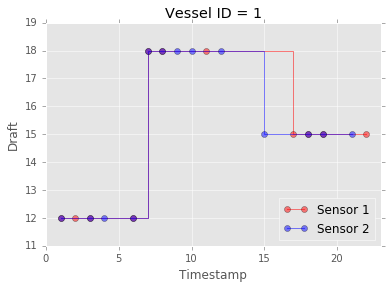

In [4]:
plot_timeseries_from_tables(['sensor1_single_vessel', 'sensor2_single_vessel'])

Let's join the draft readings from the two sensors into one time series ...

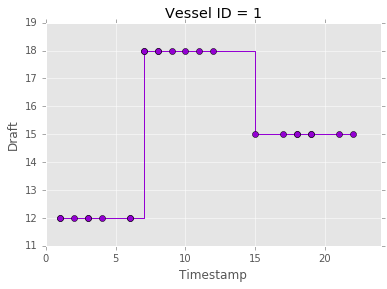

In [5]:
table_names = ['sensor1_single_vessel', 'sensor2_single_vessel']
queries = ["SELECT * FROM %s" % table_name for table_name in table_names]

# Open one DB connection per table (sensor)
conns = [sqlite3.connect('vessel_draft.sqlite') for i in range(len(table_names))]

params = zip(conns, queries)    
readers = [conn.execute(query) for (conn, query) in params]
merged = heapq.merge(*readers)

plot_timeseries(merged, where='post', color='darkviolet', marker='o')
    
for conn in conns:
    conn.close()

Voila' a merged series of sensor readings, sorted by time!

Why does this work and why is this efficient? We rely on lazy evaluation: the `readers` list contains generators over the query results, and the `merged` result is itself a generator. `heapq.merge()` does not read the data in memory to sort it. Instead it creates only the internal data structures necessary to index the underlying data, and returns a generator. When one iterates over this generator, the order in which the items are yielded is the desired sorted order over the merged streams.  

Let's take a look at the code in more detail.

* Lay out the parameters we will use and open one connection per table (sensor) to the database. We keep the connection objects in the list `conns`.

```python
table_names = ['sensor1_single_vessel', 'sensor2_single_vessel']
queries = ["SELECT * FROM %s" % table_name for table_name in table_names]

# Open one DB connection per table (sensor)
conns = [sqlite3.connect('vessel_draft.sqlite') for i in range(len(table_names))]
```
* Set up the queries. The `readers` list contains iterators over the query results, but the queries are not yet executed. Later, iterating over each `reader` object will yield a `sqlite3.Row` object from teh corresponding database table.
```python
params = zip(conns, queries)    
readers = [conn.execute(query) for (conn, query) in params]
```
* Finally, merge the iterators over the data:
```python
merged = heapq.merge(*readers)
```
Note that `merged` is itself a generator, thus very little memory is used until it is consumed by the plot function. It is really this simple!

## More realistic scenario - Two sensors and multiple vessels
But wait, there are many vessels, not just one: A vessel draft data stream is more like the one below, where readings for different vessels may arrive at the same time and different vessel `id`s are interleaved:

In [6]:
head_db('sensor1_multi_vessel', 6)

{'draft': 12.0, 'id': 1, 'time': 1}
{'draft': 5.0, 'id': 2, 'time': 1}
{'draft': 12.0, 'id': 1, 'time': 2}
{'draft': 7.0, 'id': 2, 'time': 2}
{'draft': 12.0, 'id': 1, 'time': 3}
{'draft': 7.0, 'id': 2, 'time': 3}


This presents a complication: we want to maintain the chronological order of the sensor readings for each vessel, but the data are ordered globally by timestamp because each reading is recorded in the order it arrives, irrespective of the vessel. Feeding sensor tuples as they are to `heapq.merge()` will produce an undesired result. To address this problem we do the following:
* Group together the readings from the same vessels: we can do this simply by modifying the SQL query and use the `ORDER BY` contruct. This achieves vertical ordering of the readings from each sensor.
* Re-order the tuple elements presented to `heapq.merge()` in the same way as the `ORDER BY` construct. We do this by declaring explicitly the order of the columns in the SQL `SELECT` statment. This ensures the correct horizontal ordering for the nested sorted index underlying `heapq.merge()`.

In [7]:
table_names = ['sensor1_multi_vessel', 'sensor2_multi_vessel']
# MODIFIED QUERY: nested order by id, time, draft and uses ORDER BY
queries = ["SELECT id, time, draft FROM %s ORDER BY id, time" % table_name for table_name in table_names]

# Open one DB connection per table (sensor)
conns = [sqlite3.connect('vessel_draft.sqlite') for i in range(len(table_names))]

params = zip(conns, queries)    
readers = [conn.execute(query) for (conn, query) in params]
merged = heapq.merge(*readers)

# Store in list for display
result = list(merged)
for conn in conns:
    conn.close()
    

(id, time, draft)
(1, 1, 12.0)
(1, 1, 12.0)
(1, 2, 12.0)
(1, 3, 12.0)
(1, 3, 12.0)
(1, 4, 12.0)
(1, 6, 12.0)
(1, 6, 12.0)
(1, 7, 18.0)
(1, 7, 18.0)
...
(2, 1, 5.0)
(2, 2, 7.0)
(2, 2, 7.0)
(2, 3, 7.0)
(2, 3, 7.0)
(2, 4, 7.0)
(2, 4, 7.0)
(2, 5, 7.0)
(2, 6, 10.0)
(2, 7, 10.0)


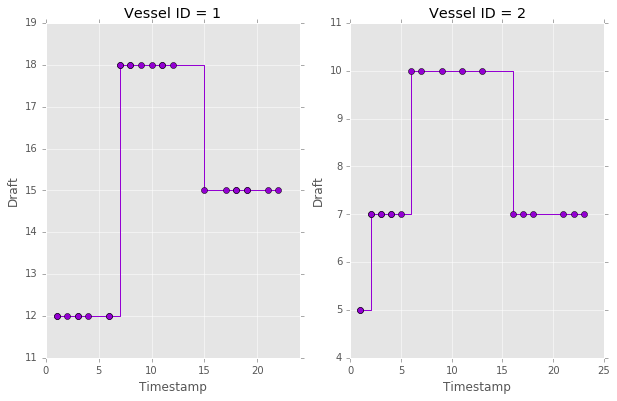

In [8]:
print "(id, time, draft)"
for row in result[:10]:
    print row
print "..."
for row in result[26:36]:
    print row
plot_multi_series(result)

There it is, a merged stream where the sensor readings for each vessel are ordered by time, and the corresponding plots.

## Detecting changes in streaming sensor data
Tipically we are interested in changes in vessel draft, not in the entire sequence of readings, because draft changes slowly compared to the sampling period of the sensor and because changes in values and the time at which they occur carry the key information about port activities and vessel behavior. Furthermore, different sensors may report redundant readings (same value, same timestamp, same vessel id) that we should filter out. We can easily filter out the redundant information and the readings for which the draft has not changed with the powerful `unique_justseen` recipe, which filters an iterable, keeping an element only if it differs from the previous one. In keeping with our goal of lazy computing, it returns an iterator over the filtered sequence, not the actual data.

I downloaded all the recipes available on the [itertools doc page](https://docs.python.org/2/library/itertools.html) and put them in a module called `itertools_recipes`. I use the recipes often, as below:

(id, time, draft)
(1, 1, 12.0)
(1, 7, 18.0)
(1, 15, 15.0)
(2, 1, 5.0)
(2, 2, 7.0)
(2, 6, 10.0)
(2, 16, 7.0)


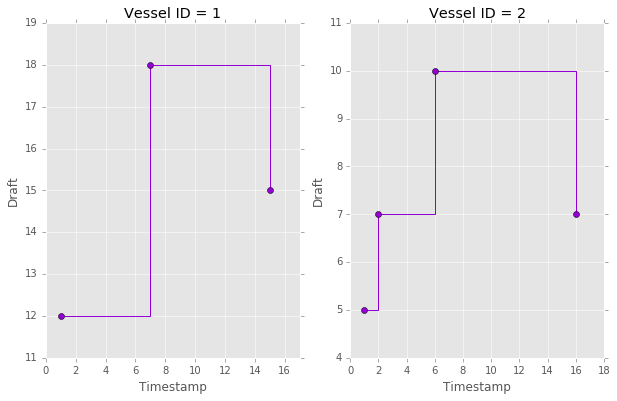

In [9]:
from itertools_recipes import unique_justseen
table_names = ['sensor1_multi_vessel', 'sensor2_multi_vessel']
queries = ["SELECT id, time, draft FROM %s ORDER BY id, time" % table_name for table_name in table_names]

# Open one DB connection per table (sensor)
conns = [sqlite3.connect('vessel_draft.sqlite') for i in range(len(table_names))]

params = zip(conns, queries)    
readers = [conn.execute(query) for (conn, query) in params]
merged = heapq.merge(*readers)

# THIS IS IT -> Change detection
change_points = unique_justseen(merged, key=lambda r: (r[0], r[2]))


change_pts_result = list(change_points)

for conn in conns:
    conn.close()
    
print "(id, time, draft)"
for row in change_pts_result:
    print row
    
plot_multi_series(change_pts_result)

And here they are, merged, parsimonious time series that capture when the draft changes, for two vessel, from two different sensors.

Note that I specified a key for `unique_everseen` to understand which part of the tuples to use for the queality comparison: I want to determine uniqueness only by the vessel id and draft values (tuple elements 0 and 2). Since the tuples are ordered by time, this results in sorted stream with duplicated draft readings for each vessel filtered out.

## Final remarks: scaling, distributing, batch and real-time processing
Don't let the simplicity of this approach fool you. It is a powerful way to combine many sources of data on small-ish compute nodes and a fundamental building block for more sophisticated analyses. In my work I use versions of it to process  $\approx$ 500 million AIS messages from 2-5 sources of AIS data from a SQL Server every month. On my HortonWorks VM running on a quad-core Intel processor, this takes approximately 15 minutes and a small blip in memory usage. It is a perfect match for batch processing of slowly-changing attributes in large datasets and it has been a huge helper for me when I need to prepare data for machine learning algorithms and visualizations. 

I deal mostly with historical analyses of data, for which higher latency is acceptable and the entire data over the period of analysis is available. Therefore, delegating the initial sorting and row ordering of the individual streams to the database is feasible and indeed desirable. This approach can be extended to geographically distributed data sources, for example to a scenario where data from hundreds of storage-capable AIS receivers provide the data streams for periodic merging.

I used the term *stream* to indicate that the data are read in sequence; it is not to be confused with real-time. If you need to merge and sort in real time, then you may need to read small buffers from the data sources in memory and perform the sorting and merging on each buffer within the Python program, accepting that you may obtain only approximate results on time windows larger than the buffer size: speed costs accuracy. Of course, then other frameworks, like [Storm](http://storm.apache.org/) and [SparkStreaming](http://spark.apache.org/streaming/) may be more appropriate, and you may also consider [Lambda Architecture](http://lambda-architecture.net/) in your system design.

#### Further reading
* [Sorting 1M 32-bit integers in 2 MB of RAM using Python](http://neopythonic.blogspot.it/2008/10/sorting-million-32-bit-integers-in-2mb.html), by Guido van Rossum
* Let your mind be blown by [Dave Beazley's](http://www.dabeaz.com) PyCon presentation on [Python generators](http://www.dabeaz.com/finalgenerator/index.html).
* Background on [AIS](https://en.wikipedia.org/wiki/Automatic_Identification_System)
* [Binary heap on Wikipedia](https://en.wikipedia.org/wiki/Binary_heap), the data structure that enables the magic in `heapq.merge()`

**License**
You may use and modify this Jupyter notebook under the terms of the [BSD license](https://opensource.org/licenses). Download the the [supporting sqlite database]({{site.baseurl}}/downloads/vessel_draft.sqlite).